# Dependence of Algorithms on Ansatz Depth

The first component of any quantum variational algorithm is the __ansatz__. Ansatz is the composition of a __reference circuit__ and a __variational form__. 
* _Reference circuit_ is the quantum circuit that prepares the reference state, a non-parametric state, that serves as the initial state for the quantum variational algorithm.
* _Variational circuit_ is a parametric circuit, consisting of parametric rotation and entangling gates.
Together, they form the ansatz.

The importance of the ansatz is better explained with an abstract example. Consider a Hamiltonian $H_p$ for a problem $P$ such that the ground state and the ground state energy of the Hamiltonian can be used to find the optimal solution to $P$. Additionally, let the Hamiltonian be an $n$ qubit Hamiltonian. Then, we know that the ground state of $H_p$ is some $n$-qubit state $|\psi_g\rangle$. The goal of the variational algorithm is to construct the ground state $|\psi_g\rangle$. Since $|\psi\rangle$ is some arbitrary $n$ qubit state (whose structure we have no idea about), the number of gates required can be as large as $O(2^n)$. This means that a perfect ansatz will involve exponentially many parameters. In that case, one can simply simulate the Hamiltonian classically without the need for quantum resources. So, it is important that the ansatz is not exponentially large. In fact, we would like an ansatz that contains polynomially many gates. But this reduces the __expressivity__ of the ansatz, or in other words, there is a reduction in the number of states that can be prepared using the ansatz. So, there is a tradeoff between the number of parameters and the expressivity of an ansatz. So, choosing the good (whatever that should mean) ansatz is hugely important.

One approach towards a good ansatz is to use some properties of the problem Hamiltonian $H_p$ to get some insight on the structure of the ground state $|\psi_g\rangle$. This could allow us to construct a small enough ansatz that will be able to prepare the ground state. For instance, if for some problem Hamiltonian, we know that the ground state takes the form $\ket{\phi(\Theta)} = \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1} e^{-i\theta_j}\ket{j}$, then it is possible to construct a polynomial-sized ansatz that explores only the states of the form $\ket{\phi(\Theta)}$. Such ansatzes are called _problem-dependent ansatz_.

Another approach, one used in QAOA-style algorithms, is to borrow the structure from quantum annealing techniques that solve the problem.

Our goal in this notebook is to investigate how the depth of the ansatz affects the performance of the algorithms. For this comparison, we use three different metrics as a proxy for the depth of an ansatz.

1. __Number of repetitions of an ansatz sub-circuit__.

Most of the ansatz is prepared by repeating an ansatz sub-circuit multiple times. For instance, the ansatz for VQE is prepared by repeating alternating layers of parametric rotations and entangling gates. Similarly, for QAOA and QAOA-style algorithms like ADAPT-QAOA and DC-QAOA, the ansatz consists of alternating circuits corresponding to the problem and the mixer Hamiltonians. In this case, the metric we use to compare algorithms is the number of repetitions of these sub-circuits, which we call _Max-Repetitions_.

2. __The depth of the ansatz circuit__.

While an equal number of repetitions naively looks like a good metric, two different algorithms that use subcircuits of different size would perform differently. The algorithm that uses the larger subcircuit gains an advantage over the other since larger circuits have more expresivity thatn smaller circuits. An alternate measure that can be consider is the _depth of the ansatz_. Two circuits of similar depth more or less take the take time to execute. So, we consider the power of algorithms when their ansatzes are of the same depth.

3. __Number of parameters__.

Similar to the depth of the ansatz being a good measure for the time on a quantum system, the number of parameters give a good measure of the time required in the classical system. For instance, a cost function with small number of parameters is relatively easy to optimize over than a cost function with large number of parameters, for any classical optimizer. So, finally, we consider the performance of algorithms when their ansatzes have same number of parameters.

### 2. Fixed Depth of the Ansatz Circuits

In this notebook, we will see how the variational algorithms compare against each other when the depth of the ansatz is similar across all the algorithms.

### Importing required functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp

import rustworkx as rx
import numpy as np
from rustworkx.visualization import mpl_draw
import matplotlib.pyplot as plt

from src.graph_gen import *
from src.hamiltonian_gen import get_hamiltonian_from_graph
from src.helper_functions import top_k_counts

In [3]:
from src.bfminimize import BFMinimizeCombinatorial
from src.qaoa import QAOA
from src.adaptqaoa import AdaptQAOA
from src.vqe import VQE
from src.dcqaoa import DCQAOA

#### Graph Generation and Brute Force Optimization

In [4]:
num_instances = 10
graph_instances = []
graph_hamiltonians = []

for i in range(num_instances):
    graph = generate_random_graph(6, 0.4)
    graph_instances.append(graph)
    cost_hamiltonian = get_hamiltonian_from_graph(graph)
    graph_hamiltonians.append(cost_hamiltonian)

In [5]:
brute_optimal_cost = []
for hamiltonian in graph_hamiltonians:
    brute = BFMinimizeCombinatorial(hamiltonian)
    brute.run()
    brute_optimal_cost.append(brute.optimal_value)

In [6]:
from qiskit_aer import AerSimulator
from qiskit.transpiler import generate_preset_pass_manager

backend = AerSimulator()
pm = generate_preset_pass_manager(backend = backend, optimization_level = 3)

max_num_layers = 10

In [7]:
# The VQE ansatz is quite straightforward.

avg_vqe_ansatz_depth = []
for reps in range(max_num_layers):
    vqe_ansatz = TwoLocal(
        graph_hamiltonians[0].num_qubits,
        rotation_blocks = ['rx'],
        entanglement_blocks = ['cz'],
        entanglement = 'full',
        reps = reps
    )
    vqe_ansatz = pm.run(vqe_ansatz)
    avg_vqe_ansatz_depth.append(vqe_ansatz.decompose(reps = 3).depth())

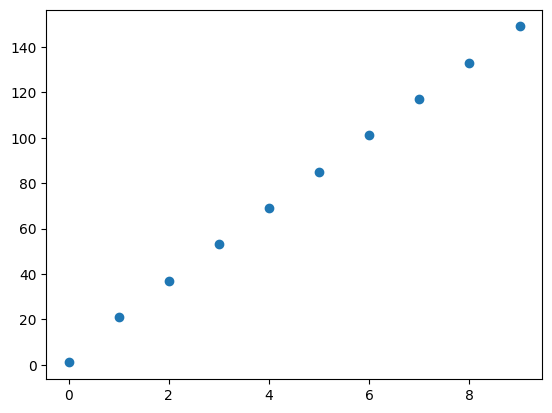

In [8]:
plt.scatter(range(max_num_layers), avg_vqe_ansatz_depth)

In [9]:
qaoa_ansatz_depth = []
for reps in range(max_num_layers):
    qaoa_ansatz_depth.append([])
    for hamiltonian in graph_hamiltonians:
        qaoa = QAOA(hamiltonian, num_layers = reps)
        qaoa_ansatz = qaoa.prepare_ansatz()
        qaoa_ansatz = pm.run(qaoa_ansatz)
        qaoa_ansatz_depth[-1].append(qaoa_ansatz.decompose(reps = 3).depth())

avg_qaoa_ansatz_depth = [ sum(depth_array)/num_instances for depth_array in qaoa_ansatz_depth ]

In [10]:
avg_dcqaoa_ansatz_depth_list = []
hamiltonian_types = [['Y'], ['XY', 'YX'], ['Y', 'XY', 'YX'], ['Y', 'XY', 'YX', 'YZ', 'ZY']]

for cd_type in hamiltonian_types:
    dcqaoa_ansatz_depth = []
    for reps in range(max_num_layers):
        dcqaoa_ansatz_depth.append([])
        for hamiltonian in graph_hamiltonians:
            dcqaoa = DCQAOA(hamiltonian, num_layers = reps, cd_hamiltonian_type = cd_type)
            dcqaoa_ansatz = dcqaoa.prepare_ansatz()
            dcqaoa_ansatz = pm.run(dcqaoa_ansatz)
            dcqaoa_ansatz_depth[-1].append(dcqaoa_ansatz.decompose(reps = 3).depth())
    
    avg_dcqaoa_ansatz_depth = [ sum(depth_array)/num_instances for depth_array in dcqaoa_ansatz_depth ]
    avg_dcqaoa_ansatz_depth_list.append(avg_dcqaoa_ansatz_depth)

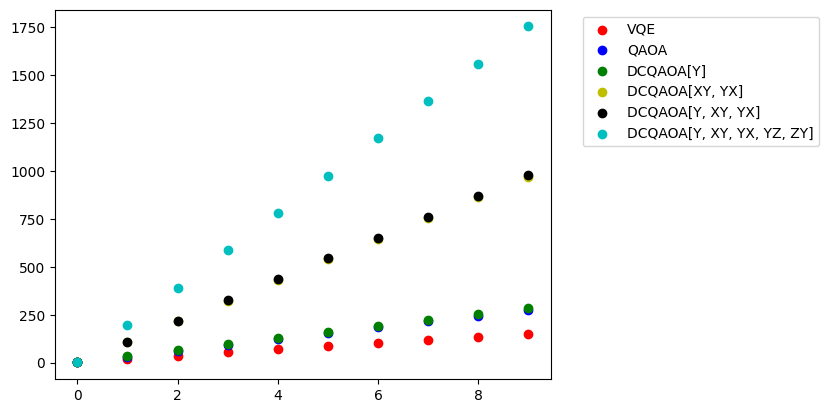

In [11]:
plt.scatter(range(max_num_layers), avg_vqe_ansatz_depth, color='r', label='VQE')
plt.scatter(range(max_num_layers), avg_qaoa_ansatz_depth, color='b', label='QAOA')
plt.scatter(range(max_num_layers), avg_dcqaoa_ansatz_depth_list[0], color='g', label='DCQAOA[Y]')
plt.scatter(range(max_num_layers), avg_dcqaoa_ansatz_depth_list[1], color='y', label='DCQAOA[XY, YX]')
plt.scatter(range(max_num_layers), avg_dcqaoa_ansatz_depth_list[2], color='k', label='DCQAOA[Y, XY, YX]')
plt.scatter(range(max_num_layers), avg_dcqaoa_ansatz_depth_list[3], color='c', label='DCQAOA[Y, XY, YX, YZ, ZY]')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

While it is quite easy to obtain the ansatz for the other variational algorithms, the only way to obtain the ansatz for ADAPT-QAOA is by solving the problem. This is because the exact subcircuits that will be used to create the optimal ansatz is dynamic in nature and is decided during the running of the ADAPT-QAOA algorithm. However, we can use information about the mixer Hamiltonians for ADAPT-QAOA to calculate the ansatz depth.

Recall that for ADAPT-QAOA that uses 'single' mixer pool type, the mixer Hamiltonian is a Hamiltonian from the set $$P_{s} = \Big\{X_i : i\in [n]\Big\} \cup \Big\{Y_i : i\in [n] \Big\} \cup \Big\{\sum_{i=1}^n X_i\Big\} \cup \Big\{\sum_{i=1}^n Y_i\Big\}.$$ Notice that the unitary corresponding to any Hamiltonian in this set will increase the depth by $1$. So, the depth of the ansatz when the number of layers is $1$ is simply $d+1$ where $d$ is the depth of the circuit corresponding to the problem Hamiltonian.

Similarly, for ADAPT-QAOA that uses 'double' mixer pool type, the mixer Hamiltonian is a Hamiltonian from the set $$P_d = P_s \cup_{i,j} \Big\{U_iV_j : U,V \in \big\{X, Y, Z \big\}\Big\}.$$ Any unitary of the form $e^{-i(A_iB_j)\theta}$ can be implemented in a circuit of depth $5$ using single qubit gates and $CX$ gates. In this case, the depth of the ansatz of $1$ layer is atmost $d+5$ ($d+1$ when the mixer Hamiltonian is from $P_s$ and $d+5$ when the mixer Hamiltonian is of the form $A_iB_j$).

So, to calculate the depth of the ansatz, it suffices to know the depth of the circuit corresponding to the problem Hamiltonian. The depth of the problem Hamiltonian itself can be calcuated using the depth of a QAOA ansatz when the number of layers is $1$. The depth of QAOA ansatz is $1$ more than the depth of the circuit corresponding to the problem Hamiltonian.

In [12]:
prob_hamil_depth = 0
for hamiltonian in graph_hamiltonians:
    qaoa = QAOA(hamiltonian, num_layers = 1)
    qaoa_ansatz = qaoa.prepare_ansatz()
    prob_hamil_depth = prob_hamil_depth + (qaoa_ansatz.decompose(reps = 3).depth() - 1)
prob_hamil_depth = prob_hamil_depth/num_instances

avg_aqaoa_single_ansatz_depth = [ reps*(prob_hamil_depth + 1) for reps in range(max_num_layers) ]
avg_aqaoa_double_ansatz_depth = [ reps*(prob_hamil_depth + 5) for reps in range(max_num_layers) ]

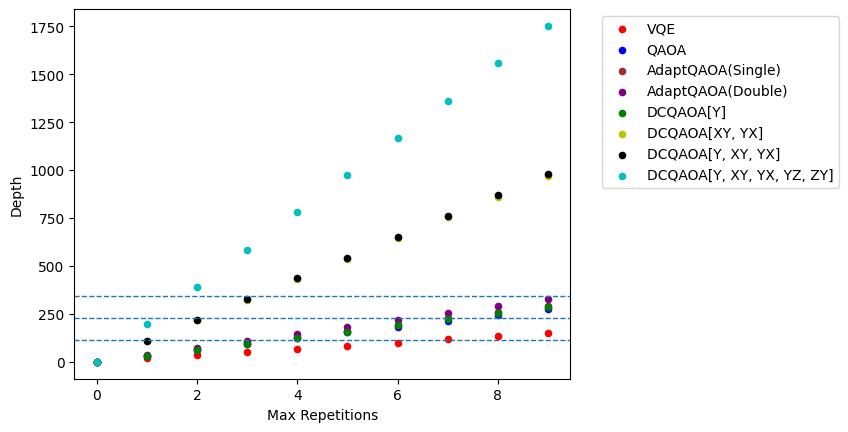

In [13]:
plt.scatter(range(max_num_layers), avg_vqe_ansatz_depth, color='r', label='VQE', s=20)
plt.scatter(range(max_num_layers), avg_qaoa_ansatz_depth, color='b', label='QAOA', s=20)
plt.scatter(range(max_num_layers), avg_aqaoa_single_ansatz_depth, color='brown', label='AdaptQAOA(Single)', s=20)
plt.scatter(range(max_num_layers), avg_aqaoa_double_ansatz_depth, color='purple', label='AdaptQAOA(Double)', s=20)
plt.scatter(range(max_num_layers), avg_dcqaoa_ansatz_depth_list[0], color='g', label='DCQAOA[Y]', s=20)
plt.scatter(range(max_num_layers), avg_dcqaoa_ansatz_depth_list[1], color='y', label='DCQAOA[XY, YX]', s=20)
plt.scatter(range(max_num_layers), avg_dcqaoa_ansatz_depth_list[2], color='k', label='DCQAOA[Y, XY, YX]', s=20)
plt.scatter(range(max_num_layers), avg_dcqaoa_ansatz_depth_list[3], color='c', label='DCQAOA[Y, XY, YX, YZ, ZY]', s=20)

plt.axhline(y=115, linestyle='--', linewidth=1)
plt.axhline(y=230, linestyle='--', linewidth=1)
plt.axhline(y=345, linestyle='--', linewidth=1)

plt.xlabel("Max Repetitions")
plt.ylabel("Depth")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

It is not a surprise that the depth of the ansatz increases linearly with the number of layers. Clearly, ansatzes for VQE has the least depth. The ansatzes for DCQAOA when the CD-Hamiltonian contains all of 'Y', 'XY', and 'YZ' terms have the most depth. The depths of the ansatz for DCQAOA with 'XY' terms and for DCQAOA with 'Y' and 'XY' terms are similar. Similarly, the ansatz depths of QAOA, ADAPT-QAOA with single and double mixer pool types, and DCQAOA with only 'Y' terms in the CD-Hamiltonian are of the same order.

We want to compare the performance of different algorithms that have the same ansatz depth. For this purpose, we consider the depths of $115, 230$, and $345$. 

We can note that VQE with $6$ layers, QAOA and ADAPT-QAOA with $3$ layers, and DCQAOA\['XY', 'YX'\] with $1$ layer have ansatzes with depth approximately $115$. Similarly, VQE with $12$ layers, QAOA and ADAPT-QAOA with $6$ layers, and DCQAOA\['XY', 'YX'\] with $2$ layers have ansatzes of depth approximately $230$. Finally, VQE with $18$ layers, QAOA and ADAPT-QAOA with $9$ layers, and DCQAOA\['XY', 'YX'\] with $3$ layers have ansatzes of depth approximately $345$.

##### Algorithm settings with Ansatz depth approximately $115$:
1. VQE - $6$ layers.
2. QAOA - $3$ layers.
3. ADAPT-QAOA (Single) - $3$ layers.
4. ADAPT-QAOA (Double) - $3$ layers.
5. DCQAOA \['XY', 'YX'\] - $1$ layers.

##### Algorithm settings with Ansatz depth approximately $230$:
1. VQE - $12$ layers.
2. QAOA - $6$ layers.
3. ADAPT-QAOA (Single) - $6$ layers.
4. ADAPT-QAOA (Double) - $6$ layers.
5. DCQAOA \['XY', 'YX'\] - $2$ layers.

##### Algorithm settings with Ansatz depth approximately $345$:
1. VQE - $18$ layers.
2. QAOA - $9$ layers.
3. ADAPT-QAOA (Single) - $9$ layers.
4. ADAPT-QAOA (Double) - $9$ layers.
5. DCQAOA \['XY', 'YX'\] - $3$ layers.

### Solving MIS using each algorithm with appropriate depth settings

#### VQE

In [14]:
vqe_reps = [6, 12, 18]
avg_vqe_error = []

for reps in vqe_reps:
    print(f"Solving for reps {reps}...")
    vqe_rep_optimal_costs = []
    for hamiltonian in graph_hamiltonians:
        vqe_ansatz = TwoLocal(
                    hamiltonian.num_qubits,
                    rotation_blocks = ['rx'],
                    entanglement_blocks = ['cz'],
                    entanglement = 'full',
                    reps = reps,
                )
        vqe = VQE(hamiltonian, ansatz = vqe_ansatz)
        vqe.run()
        vqe_rep_optimal_costs.append(vqe.optimal_value)
    vqe_error = [np.abs(b_opt - v_opt) for b_opt, v_opt in zip(brute_optimal_cost, vqe_rep_optimal_costs)]
    avg_vqe_error.append(sum(vqe_error)/num_instances)

Solving for reps 6...
Solving for reps 12...
Solving for reps 18...


#### QAOA

In [15]:
qaoa_reps = [3, 6, 9]
avg_qaoa_error = []

for reps in qaoa_reps:
    print(f"Solving for reps {reps}...")
    qaoa_rep_optimal_costs = []
    for hamiltonian in graph_hamiltonians:
        qaoa = QAOA(hamiltonian, num_layers = reps)
        qaoa.run()
        qaoa_rep_optimal_costs.append(qaoa.optimal_value)
    qaoa_error = [np.abs(b_opt - q_opt) for b_opt, q_opt in zip(brute_optimal_cost, qaoa_rep_optimal_costs)]
    avg_qaoa_error.append(sum(qaoa_error)/num_instances)

Solving for reps 3...
Solving for reps 6...
Solving for reps 9...


#### ADAPT-QAOA (Single)

In [16]:
aqaoa_single_reps = [3, 6, 9]
avg_aqaoa_single_error = []

for reps in qaoa_reps:
    print(f"Solving for reps {reps}...")
    aqaoa_single_rep_optimal_costs = []
    for hamiltonian in graph_hamiltonians:
        aqaoa_single = AdaptQAOA(hamiltonian, max_num_layers = reps, mixer_pool_type = 'single')
        aqaoa_single.run()
        aqaoa_single_rep_optimal_costs.append(aqaoa_single.optimal_value)
    aqaoa_single_error = [np.abs(b_opt - a_s_opt) for b_opt, a_s_opt in zip(brute_optimal_cost, aqaoa_single_rep_optimal_costs)]
    avg_aqaoa_single_error.append(sum(aqaoa_single_error)/num_instances)

Solving for reps 3...
Solving for reps 6...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
Solving for reps 9...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.


#### ADAPT-QAOA (Double)

In [17]:
aqaoa_double_reps = [3, 6, 9]
avg_aqaoa_double_error = []

for reps in qaoa_reps:
    print(f"Solving for reps {reps}...")
    aqaoa_double_rep_optimal_costs = []
    for hamiltonian in graph_hamiltonians:
        aqaoa_double = AdaptQAOA(hamiltonian, max_num_layers = reps, mixer_pool_type = 'double')
        aqaoa_double.run()
        aqaoa_double_rep_optimal_costs.append(aqaoa_double.optimal_value)
    aqaoa_double_error = [np.abs(b_opt - a_d_opt) for b_opt, a_d_opt in zip(brute_optimal_cost, aqaoa_double_rep_optimal_costs)]
    avg_aqaoa_double_error.append(sum(aqaoa_double_error)/num_instances)

Solving for reps 3...
Solving for reps 6...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
Solving for reps 9...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.


#### DCQAOA \['XY', 'YX'\]

In [18]:
dcqaoa_reps = [3, 6, 9]
avg_dcqaoa_error = []

for reps in qaoa_reps:
    print(f"Solving for reps {reps}...")
    dcqaoa_rep_optimal_costs = []
    for hamiltonian in graph_hamiltonians:
        dcqaoa = DCQAOA(hamiltonian, num_layers = reps, cd_hamiltonian_type = ['XY', 'YX'])
        dcqaoa.run()
        dcqaoa_rep_optimal_costs.append(dcqaoa.optimal_value)
    dcqaoa_error = [np.abs(b_opt - q_opt) for b_opt, q_opt in zip(brute_optimal_cost, dcqaoa_rep_optimal_costs)]
    avg_dcqaoa_error.append(sum(dcqaoa_error)/num_instances)

Solving for reps 3...
Solving for reps 6...
Solving for reps 9...


#### Plotting the results

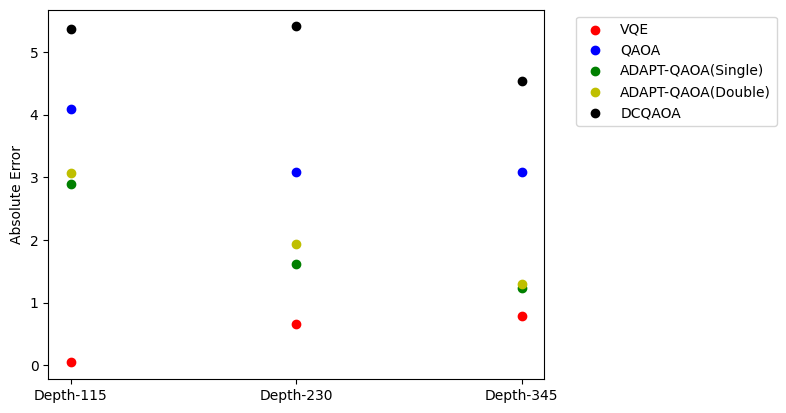

In [20]:
plt.scatter(range(3), avg_vqe_error, color = 'r', label = 'VQE')
plt.scatter(range(3), avg_qaoa_error, color = 'b', label = 'QAOA')
plt.scatter(range(3), avg_aqaoa_single_error, color = 'g', label = 'ADAPT-QAOA(Single)')
plt.scatter(range(3), avg_aqaoa_double_error, color = 'y', label = 'ADAPT-QAOA(Double)')
plt.scatter(range(3), avg_dcqaoa_error, color = 'k', label = 'DCQAOA')

plt.xticks([0, 1, 2], ['Depth-115', 'Depth-230', 'Depth-345'])
# plt.xlabel('Depth')
plt.ylabel('Absolute Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can observe that VQE performs the best when the depth of the ansatzes is fixed to the depths considered. The performance of VQE could be attributed to the high expressivity of the VQE ansatz even at lower depths, or VQE's better compatibility with the MIS problem. But as the depth is increased, the ADAPT-QAOA with both the single and the double mixer pool types starts to perform better. At a depth of approximately $345$, the ADAPT-QAOA's performance is almost as good as that of VQE. The performance of ADAPT-QAOA with the double mixer pool is slightly better than ADAPT-QAOA with the single mixer pool, implying the expressivity of the prior is better than the latter, as is expected. 

As for QAOA and DCQAOA, their performance is bad, and it barely improves with an increase in the depth. However, even a depth of approximately $345$ layers is considered small, and QAOA is known to perform better when the depth is large. This is due to the fact that QAOA essentially simulates quantum annealing, and so a slow rate of driving evolves the initial state to a state that is closer to the ground state of the problem Hamiltonian than a faster driving.

Note that the absolute error of the ADAPT-QAOA decreases significantly as the depth increases. This is an expected behaviour, since the expressivity of the ansatzes increases with an increase in depth, and so the algorithm would be able to reach closer to the ground state and the optimal solution. On the other hand, the decrease in absolute error is very minimal for QAOA and DCQAOA. Surprisingly, contrary to the other algorithms, the absolute error of VQE increases as the depth increases! This could be a result of confusion and a complex cost landscape due to the presence of a large number of parameters.

